## |-----1D  Richards'  Equation for Soil Infiltration-----|
Samantha Motz -- Leah Hornsey

December  6th, 2022

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
import math

## INTRODUCTION
In a world of changing climate, understanding the hydrologic cycle is crucial as water resources will continue to be stressed. However, quantifying fluxes within the hydrologic cycle has always been an extremely difficult task as they require us to define a space, make assumptions, and at times ignore parameters. Infiltration is one such flux that quantifies the amount of water from the ground surface entering into the soil and is especially important in providing insight into groundwater recharge, flood risk, and the risk of dissolved pollutants.

There are many ways to study infiltration. In the field, hydrologists use infiltrometers and permeameters to take point measurements of the infiltration rate. Several models exist to model infiltration from the traditional, the Richards Equation presented here, which is based on the water balance equation to the modern Green-Ampt Model, which is based on a combination of the water balance equation and Darcy's Law.

## EQUATIONS

We are focused on modeling the 1D Richard's Equation (in addition one of its cruical outputs) which describes water flow in the unsaturated zone and is displayed below.

∂θ/∂t = ∇ * K(h) * (∇h + ∇z) - S

Where θ (m ** 3 / m ** 3) is volumetric water content defined by the retention curve: θ / θ_s = (h / h_e) ** -lam = 1. S (1 / s) is a sink term. h (m) is the pressure head, z (m) is the depth pointed positively downwards, t (s) is time, and K (m / s) is hydraulic conductivity defined by the following statements:

if h < h_e then: K / K_s = (θ / θ_s) ** eta elseif h >= then: K / K_s = 1

h_e (m) is the air entry pressure, θ_s (m ** 3 / m ** 3) is the volumetric water content at saturation, K_s (m / s) is the hydraulic conductivity at saturation, and lambda and eta are shape parameters.

Overall, the Richards equation simplifies for easy one-dimenional infiltration becoming a deviation of the diffusion equation:

∂θ/∂t = ∂/∂z * (K(θ) * (∂h/∂z + 1)) - S

The important process we can model with the Richard's Equation is cumulative infiltration, which is how much water over time flows from the ground surface into the soil. In the broadest sense, infiltration is a balancing act between gravitational and capillary forces acting upon water, this is described in the following equation:

I - K_0 * t = z_s * [θ_s - θ_0] + ((S2_orp(θ_0,θ_s)) / (2 * betta(θ_0,θ_s) * [K_s - K_0])) * ln[1 + betta(θ_0,θ_s) * ((K_s - K_0) / (q1 - K_s))]

Where K_0 and θ_0 are initial conditions, and z_s is a reference level separating the saturated and unsaturated zones. S2_orp is sorptivity, or simply what describes capillary force in the soil column and has an equation of S2_orp = C_sbc * θ_s * abs(h_e) * K_s, where Csbc is defined as equaling 2 + (1 / (lam * eta - 1)) + (1 / (lam * eta - 1 + lam)). Betta is a parameter descibed based on the equation of betta = 2 * (1 - 2 * (C_betbc / C_sbc)), where C_beta = 1 + (1 / (2 * lam * eta - lam - 1)).

All of this assumes some level of saturation, however if we assume the case of a saturated surface boundary condition and the soil column is dry initially, then cumulative infiltration simplifies significantly as we don't need to consider initial saturation:

I = (S2_orp / (2 * betta * K_s)) * ln(1 + (betta /(q / K_s) - 1))

Note: eta is assumed to be equal to lambda We assume the system is root-less and therefore S is zero. Boundary Conditions: dS[0] = 0 z_s = 0 q0 = 15 mm/hr

In [7]:
#%%----- Parameters -----%%#
#___Based on soil type: Sand___#
h_e = -0.1 * 1000           # Air Entry Pressure (mm)
K_s = 20 * 1000 * 3600      # Hydraulic Conductivity at Saturation (mm / hr)
lam = 9                     # Shape Parameter
eta = 9                     # Shape Parameter
theta_s = 0.4 / 1000000000  # Volumetric Water Content at Saturation (mm ** 3 / mm ** 3) ~NOTE: if things seem weird this may not need to be scaled since the units technically cancel out, but uncertain since it is not nondimensional.
theta_r = 0.2 / 1000000000  # Initial Volumetric Water Content (mm ** 3 / mm ** 3)
b = 3                       # Hydrologic Parameter
q0 = 15                     # Initial Flux (mm / hr)
D = 0.1                     # Diffusivity
phi = 0.38                  # Porosity

#%%----- Functions  -----%%#
theta = lambda h,dt: theta_s * (h / h_e) ** -lam * dt  # theta
h = lambda theta: h_e * (((phi - theta_r) / (theta - theta_r)) ** (1 + b) - 1) ** (b / 1 + b) # Tension hydraulic head
#K_theta = K_s * ((h(theta_s) - theta_r) / (phi - theta_r)) ** (2 * b + 3)   # Hydraulic Conductivity in relation to soil moisture
# assumes hydraulic conductivity is constant
C_sbc = 2 + (1 / (lam * eta - 1)) + (1 / (lam * eta - 1 + lam))          # Retention Curve
S2_orp = C_sbc * theta_s * np.abs(h_e) * K_s    # Sorptivity
C_betbc = 1 + (1 / (2 * lam * eta - lam - 1))   # Hydraulic Conductivity Curve
betta = 2 * (1 - 2 * (C_betbc / C_sbc))         # Parameter

## NUMERICAL METHODS

We are simulating infiltration through soil using the Forward Euler on a diffusion equation with a Neumann boundary condition. Forward Euler is used to model flux (q), which is plugged into the 1-D Richards equation for infiltration. Forward Euler has chosen because we are treating soil infiltration as a diffusion process.

In [11]:
#%%----- Time steps -----%%#
n = 100
x = np.linspace(0,eta,n)
dx = x[1] - x[0]
C_D = 0.1                                       # Diffusion Constant
dt = (dx ** 2) * C_D / D

tf = 10                                         # Final Time (hr)
nt = round(tf / dt)

t = np.linspace(0,tf,nt + 1)                    # Vectorizing Time

#%%----- Model Grid -----%%#
data = np.array([np.ones(n), np.ones(n), np.ones(n)]) ##### ***** DOES THIS NEED C_D? ***** #####
diags = np.array([-1, 0, 1])
dtheta = spdiags(data, diags, n+1, n+1).toarray()

#%%-- Pre-Allocations  --%%#
data = np.array([C_D * np.ones(n), (1 - 2 * C_D) * np.ones(n), C_D * np.ones(n)])
diags = np.array([-1, 0, 1])
q = spdiags(data, diags, n+1, n+1).toarray()
q[0,0] = q0
q[0,1] = q0
q[-1,-1] = 0
q[-1,-2] = 0

data = np.array([np.ones(n), np.ones(n), np.ones(n)])
diags = np.array([-1, 0, 1])
I = spdiags(data, diags, n+1, n+1).toarray()

dh = np.zeros(n+1)
dh[0] = h_e

the = np.zeros(n+1)
the[0] = theta_r

#dtheta = np.zeros(n)
dtheta[0] = theta_r

#%%---- Solve for Richards Equation ----%%#
for i in np.arange(0,n):
    if i == 0:
        dh[i + 1] = dh[i] + h(theta_s)
        the[i + 1] = theta(dh[i],t[i])
        dtheta[i,:] = K_s * (dh[i] + 1)
    else:
        dh[i + 1] = dh[i] + h(the[i])
        the[i + 1] = theta(dh[i],t[i])
        dtheta[i + 1,:] = K_s * (dh[i] + 1)

J = lambda i, k: K_s * (h(dtheta[i,k]))   # theta
I[:,0] = (S2_orp / (2 * betta * K_s)) * np.log(1 + (betta /(q0 / K_s) - 1))

# Then use this value as a Neumann condition to solve for q...
for k in np.arange(0,n):
    #q[:, k+1] = q[:,k] + C_D*(K_s * (dh(dtheta[:,k])))
    q[:, k+1] = q[i,k] + C_D*(((J(2,k) - 2 * J(1,k))/dx)-(J(1,k)*(q0/D))) #Neumann condition
    I[:, k + 1] = (S2_orp / (2 * betta * K_s)) * np.log(1 + (betta /(q[:,k] / K_s) - 1))
    
#HILLSLOPE DEMO- FORWARD EULER

#dtheta_dt = np.gradient(dtheta, dx) #One-dimensional infiltration equation

#%%----- Model Grid -----%%#
#data = np.array([C_D * np.ones(n), (1 - 2 * C_D) * np.ones(n), C_D * np.ones(n)])
#diags = np.array([-1, 0, 1])
#M = spdiags(data, diags, n, n).toarray()

#%%-- Pre-Allocations  --%%#
#J = np.zeros((len(x), len(t)))
#J[:,0] = 

#%%---- Initial Soln ----%%#
#for k in range(0,len(time)-1):
#    J[:,k+1] = M@J[:,k]
    
##-----Forward  Euler-----##
# Forward Euler for the diffusion equation


##-----Centered Euler-----##



#%%------ Matrices ------%%#

/tmp/ipykernel_5510/2559092015.py:58: RuntimeWarning: divide by zero encountered in true_divide
  I[:, k + 1] = (S2_orp / (2 * betta * K_s)) * np.log(1 + (betta /(q[:,k] / K_s) - 1))
/tmp/ipykernel_5510/2559092015.py:58: RuntimeWarning: divide by zero encountered in log
  I[:, k + 1] = (S2_orp / (2 * betta * K_s)) * np.log(1 + (betta /(q[:,k] / K_s) - 1))


## RESULTS

## FIGURES

ValueError: x and y must have same first dimension, but have shapes (1212,) and (101, 101)

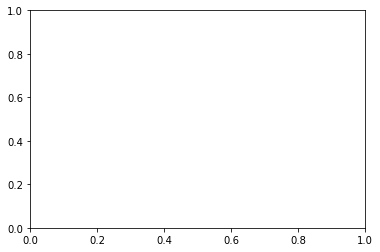

In [14]:
#%%------ Plotting ------%%#
figure = plt.figure()
plt.plot(t,I,'k-')
plt.xlabel('Time (hr)')
olt.ylabel('Infiltration ()')

## VIDEO WALKTHROUGH


## REFERENCES

Bras, R.L. (1989). Hydrology - An Introduction to Hydrological Science, Addison-Wesley. 

N. Varado, I. Braud, P.J. Ross, R. Haverkamp. (2006). Assessment of an efficient numerical solution of the 1D Richards' equation on bare soil, Journal of Hydrology, 323 (1–4), 244-257, https://doi.org/10.1016/j.jhydrol.2005.07.052.